# initial setup and importation


In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# Set Optuna logging verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Print file paths in the specified directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Preprocessing and cleaning

### read the datasets

In [70]:
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

test.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                  10   
1               0       0    0  ...             255                   1   
2               0       0    0  ...             134                  86   
3               0       0    0  ...               3                  57   
4               0       0    0  ...              29                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3                    1.00                    0.00   
4                    0.31                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  
0                      1.00  
1                      1.00  
2                      0.00  
3                      0.00  
4                      0.71  

[5 rows x 41 columns]

# check the train dataframe

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

### inspect the train dataset

In [72]:
train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

### describe the train dataframe

In [73]:
train.describe()

duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  25192.000000  2.519200e+04  2.519200e+04  25192.000000    25192.000000   
mean     305.054104  2.433063e+04  3.491847e+03      0.000079        0.023738   
std     2686.555640  2.410805e+06  8.883072e+04      0.008910        0.260221   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  4.400000e+01  0.000000e+00      0.000000        0.000000   
75%        0.000000  2.790000e+02  5.302500e+02      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.151385e+06      1.000000        3.000000   

            urgent           hot  num_failed_logins     logged_in  \
count  25192.00000  25192.000000       25192.000000  25192.000000   
mean       0.00004      0.198039           0.001191      0.394768   
std        0.00630      2.154202           0.045418      0.488811   
min        0.00000      0.000000           0.000000      0.000000   
25%        0.00000      0.000000           0.000000      0.000000   
50%        0.00000      0.000000           0.000000      0.000000   
75%        0.00000      0.000000           0.000000      1.000000   
max        1.00000     77.000000           4.000000      1.000000   

       num_compromised  ...  dst_host_count  dst_host_srv_count  \
count     25192.000000  ...    25192.000000        25192.000000   
mean          0.227850  ...      182.532074          115.063036   
std          10.417352  ...       98.993895          110.646850   
min           0.000000  ...        0.000000            0.000000   
25%           0.000000  ...       84.000000           10.000000   
50%           0.000000  ...      255.000000           61.000000   
75%           0.000000  ...      255.000000          255.000000   
max         884.000000  ...      255.000000          255.000000   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
count            25192.000000            25192.000000   
mean                 0.519791                0.082539   
std                  0.448944                0.187191   
min                  0.000000                0.000000   
25%                  0.050000                0.000000   
50%                  0.510000                0.030000   
75%                  1.000000                0.070000   
max                  1.000000                1.000000   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
count                 25192.000000                 25192.000000   
mean                      0.147453                     0.031844   
std                       0.308367                     0.110575   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       0.060000                     0.020000   
max                       1.000000                     1.000000   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
count          25192.000000              25192.000000          25192.000000   
mean               0.285800                  0.279846              0.117800   
std                0.445316                  0.446075              0.305869   
min                0.000000                  0.000000              0.000000   
25%                0.000000                  0.000000              0.000000   
50%                0.000000                  0.000000              0.000000   
75%                1.000000                  1.000000              0.000000   
max                1.000000                  1.000000              1.000000   

       dst_host_srv_rerror_rate  
count              25192.000000  
mean                   0.118769  
std                    0.317333  
min                    0.000000  
25%                    0.000000  
50%                  

In [74]:
train.describe(include='object')

protocol_type service   flag   class
count          25192   25192  25192   25192
unique             3      66     11       2
top              tcp    http     SF  normal
freq           20526    8003  14973   13449

### Handling Missing Data

In [75]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values

### Check for Duplicates 

In [76]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


### DAtaframe  Label Encoding

In [77]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

### Dropping the 'num_outbound_cmds' Column from Train and Test Data


In [78]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       45     1          0          0     0   
1         0              1       45     1          0          0     0   
2         2              1       19     9      12983          0     0   
3         0              0       13     9         20          0     0   
4         1              1       55     2          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_count  dst_host_srv_count  \
0               0       0    0  ...             255                  10   
1               0       0    0  ...             255                   1   
2               0       0    0  ...             134                  86   
3               0       0    0  ...               3                  57   
4               0       0    0  ...              29                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61                    0.04   
3                    1.00                    0.00   
4                    0.31                    0.17   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.00                         0.00   
1                         0.00                         0.00   
2                         0.61                         0.02   
3                         1.00                         0.28   
4                         0.03                         0.02   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  1.00   
1                   0.0                       0.0                  1.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  0.83   

   dst_host_srv_rerror_rate  
0                      1.00  
1                      1.00  
2                      0.00  
3                      0.00  
4                      0.71  

[5 rows x 40 columns]

### Splitting the Data into Features and Target


In [79]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

### Feature Selection using Recursive Feature Elimination (RFE)


In [80]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

### Selecting the Top Features for Training


In [81]:
X_train = X_train[selected_features]


### Scaling the Training and Test Data


In [82]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

### Splitting the Data into Training and Testing Sets


In [83]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

## K Nearest Neighbors (KNN) classification model

#### Defining the Objective Function for Hyperparameter Tuning with Optuna


In [84]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

### Running the Optuna Study for Hyperparameter Optimization


In [85]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.9829319925906325], datetime_start=datetime.datetime(2024, 8, 7, 0, 23, 42, 298649), datetime_complete=datetime.datetime(2024, 8, 7, 0, 23, 45, 987111), params={'KNN_n_neighbors': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


### Training and Evaluating the K-Nearest Neighbors (KNN) Model


In [87]:
# Initialize the KNN model with the best parameters from the Optuna study
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])

# Fit the model on the training data
KNN_model.fit(x_train, y_train)

# Evaluate the model on both training and test data
KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

# Print the training and test scores
print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9920607916524895
Test Score: 0.9829319925906325


### Training and Evaluating the Logistic Regression Model


In [88]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lg_model = LogisticRegression(random_state=42)

# Fit the model on the training data
lg_model.fit(x_train, y_train)

# Evaluate the model on both training and test data
lg_train_score = lg_model.score(x_train, y_train)
lg_test_score = lg_model.score(x_test, y_test)

# Print the training and test scores
print(f"Logistic Regression Train Score: {lg_train_score}")
print(f"Logistic Regression Test Score: {lg_test_score}")

Logistic Regression Train Score: 0.9288873766587274
Logistic Regression Test Score: 0.9233924318602805


### Running the Optuna Study for Hyperparameter Optimization of Decision Tree


In [89]:
# Create an Optuna study to maximize the accuracy of the Decision Tree classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the best parameters and accuracy
print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

Best parameters: {'KNN_n_neighbors': 3}
Best accuracy: 0.9843874040751521


### Training and Evaluating the Decision Tree Model with Optimized Hyperparameters


In [91]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

FrozenTrial(number=26, state=1, values=[0.9960306959513099], datetime_start=datetime.datetime(2024, 8, 7, 0, 32, 12, 26421), datetime_complete=datetime.datetime(2024, 8, 7, 0, 32, 12, 166689), params={'dt_max_depth': 29, 'dt_max_features': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=26, value=None)
Train Score: 1.0
Test Score: 0.9955014554114845


### Visualizing the Decision Tree


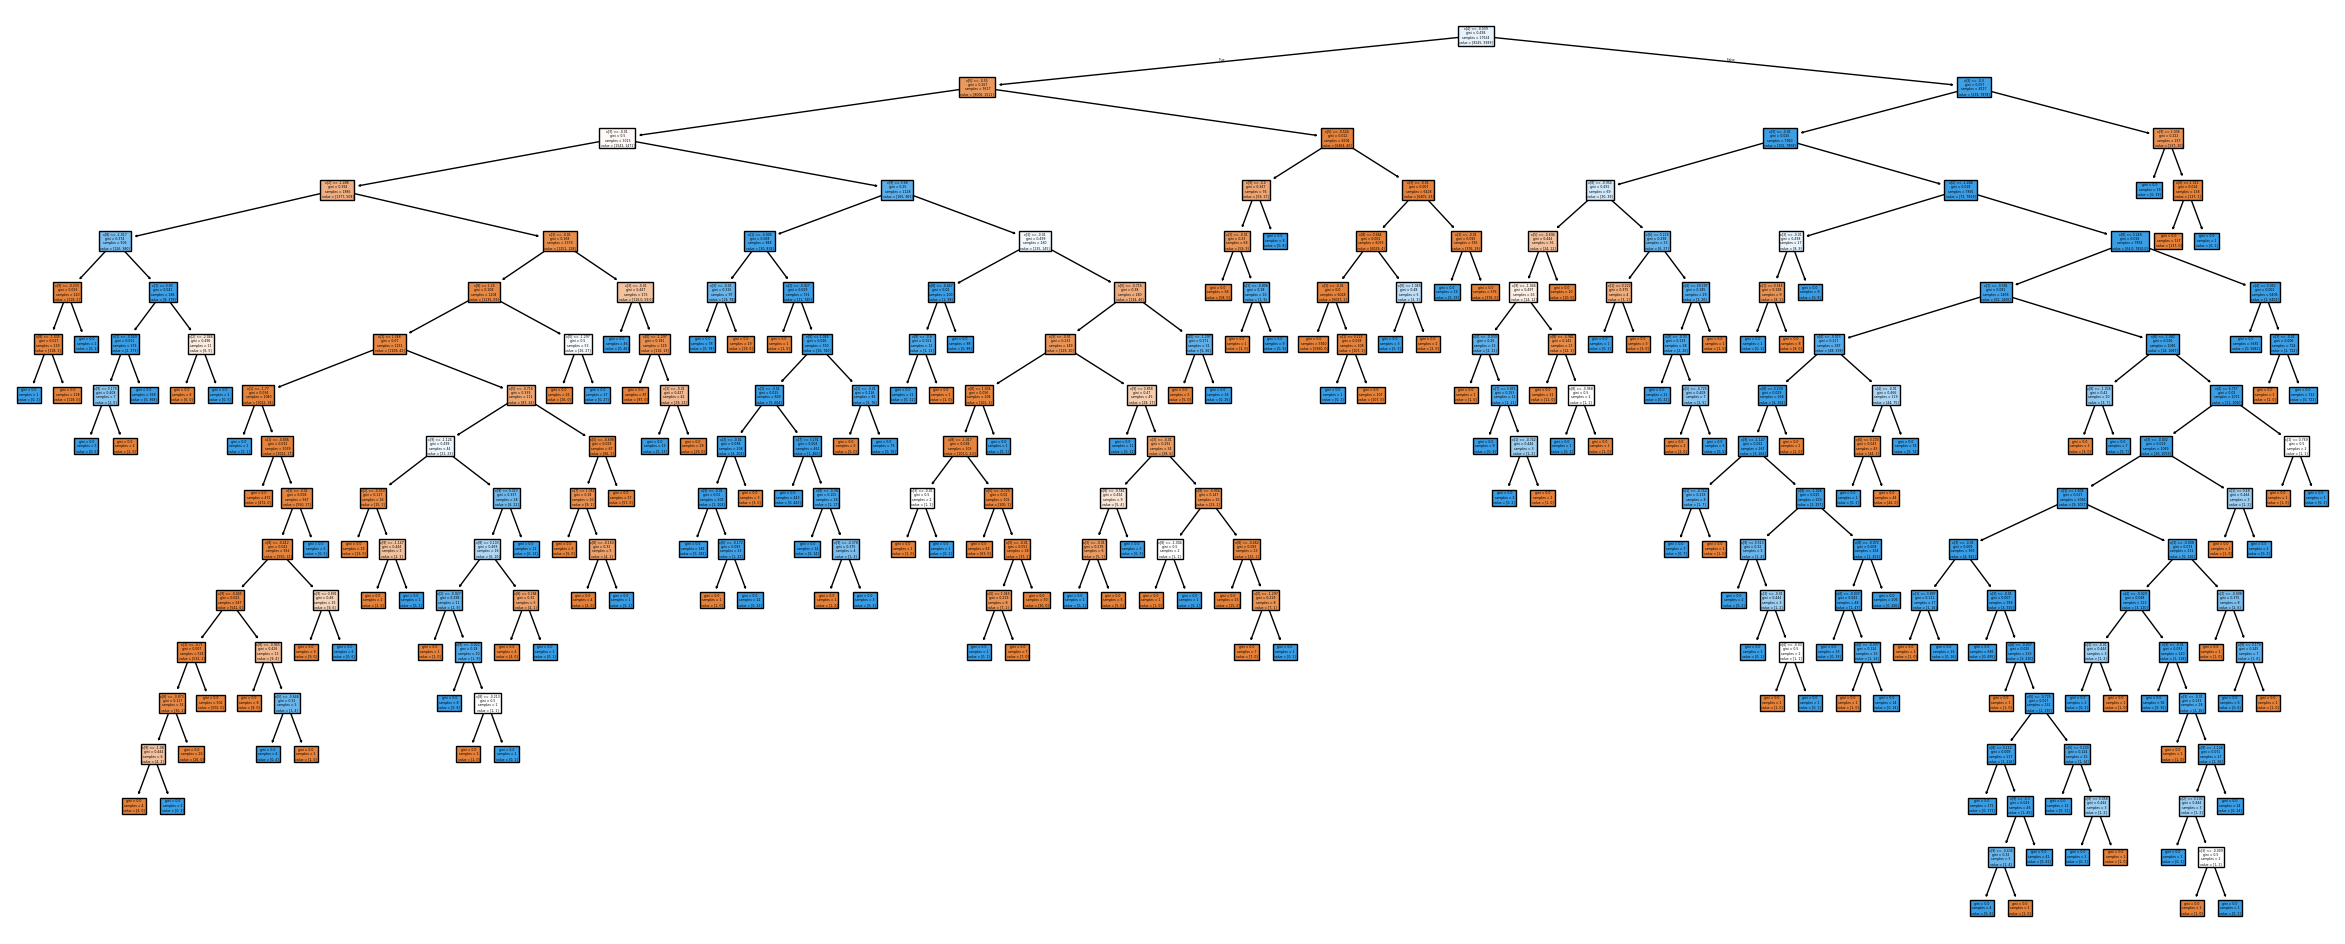

In [92]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

### Visualizing Feature Importance for Decision Tree


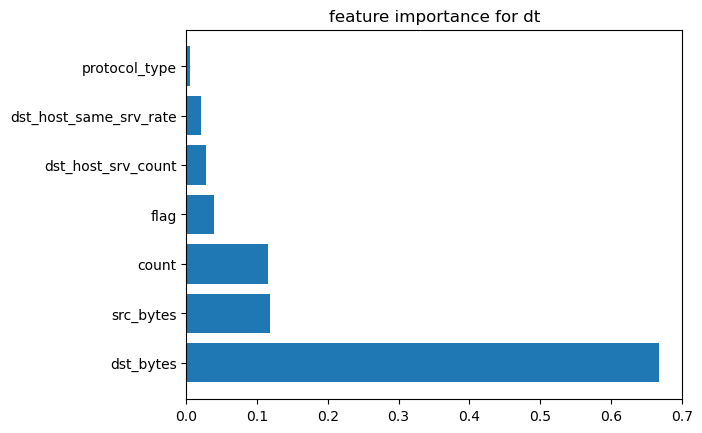

In [93]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importance(abs(dt.feature_importances_), features_names, top=7)

### Running the Optuna Study for Hyperparameter Optimization of Random Forest


In [94]:
# Create an Optuna study to maximize the accuracy of the Random Forest classifier
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the best parameters and accuracy
print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value}")

Best parameters: {'dt_max_depth': 13, 'dt_max_features': 9}
Best accuracy: 0.9960306959513099


### Training and Evaluating the Random Forest Model with Optimized Hyperparameters


In [96]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

FrozenTrial(number=25, state=1, values=[0.9968245567610479], datetime_start=datetime.datetime(2024, 8, 7, 0, 34, 29, 215330), datetime_complete=datetime.datetime(2024, 8, 7, 0, 34, 30, 126822), params={'rf_max_depth': 14, 'rf_max_features': 6, 'rf_n_estimators': 19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=25, value=None)
Train Score: 0.9999432913689463
Test Score: 0.9965599364911352


### Visualizing Feature Importance for Random Forest


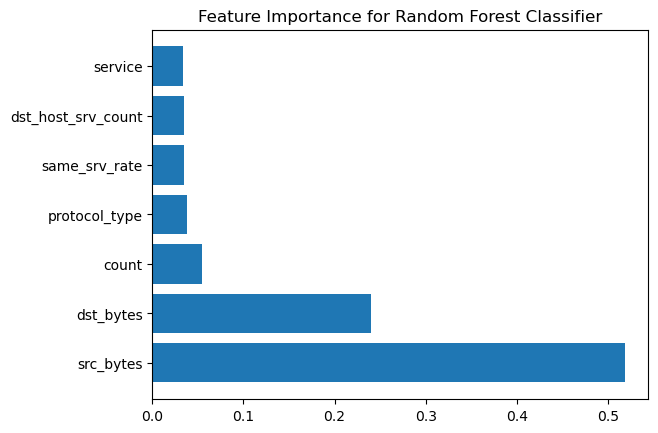

In [98]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features if top is not specified
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature Importance for Random Forest Classifier')
    plt.show()

# Feature names from the selected features
features_names = selected_features

# Visualize the top 7 features
f_importance(abs(rf.feature_importances_), features_names, top=7)

# SKLearn Gradient Boosting Model training

In [99]:
SKGB = GradientBoostingClassifier(random_state=42)
SKGB.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

### Evaluating the Gradient Boosting Classifier


In [100]:
# Evaluate the model on both training and test data
gb_train_score = SKGB.score(x_train, y_train)
gb_test_score = SKGB.score(x_test, y_test)

# Print the training and test scores
print(f"Gradient Boosting Train Score: {gb_train_score}")
print(f"Gradient Boosting Test Score: {gb_test_score}")

Gradient Boosting Train Score: 0.9947828059430646
Gradient Boosting Test Score: 0.9927229425774015


# XGBoost Gradient Boosting Model training

In [101]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [102]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 1.0
Test Score: 0.9960306959513099


# Light Gradient Boosting Model training


In [103]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [104]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 1.0
Test Score: 0.9965599364911352


# SKLearn AdaBoost Model training

In [105]:
ab_model = AdaBoostClassifier(random_state=42)

In [106]:
ab_model.fit(x_train, y_train)

AdaBoostClassifier(random_state=42)

In [107]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.9800385618691165
Test Score: 0.9790949986768986


# CatBoost Classifier Model training


In [108]:
cb_model = CatBoostClassifier(verbose=0)

In [109]:
cb_model.fit(x_train, y_train)

In [110]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9985822842236588
Test Score: 0.9956337655464409


# Naive Bayes Model training 


In [111]:
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)

BernoulliNB()

### naive bayes model score

In [112]:
BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8975842123171147
Test Score: 0.8970627150039693


# Voting Model 

In [113]:
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")

In [114]:
v_clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=2)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_po...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000018ADB0A08F0>)])

In [115]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 1.0
Test Score: 0.9961630060862662


# Saving all the trained models

In [116]:
data = [["KNN", KNN_train, KNN_test], 
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test], 
        ["Random Forest", rf_train, rf_test], 
        ["GBM", SKGB_train, SKGB_test], 
        ["XGBM", xgb_train, xgb_test], 
        ["Adaboost", ab_train, ab_test], 
        ["light GBM", lgb_train, lgb_test],
        ["CatBoost", cb_train, cb_test], 
        ["Naive Baye Model", BNB_train, BNB_test], 
        ["Voting", voting_train, voting_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.992061 │     0.982932 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.928887 │     0.923392 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      1        │     0.995501 │
├─────────────────────┼───────────────┼──────────────┤
│ Random Forest       │      0.999943 │     0.99656  │
├─────────────────────┼───────────────┼──────────────┤
│ GBM                 │      0.994783 │     0.992723 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      1        │     0.996031 │
├─────────────────────┼───────────────┼──────────────┤
│ Adaboost            │      0.980039 │     0.979095 │
├─────────────────────┼───────────────┼──────────────┤
│ light GBM           │      1        │     0.99656  │
├─────────

## Save all the models using joblibs for the frontend apk

In [117]:
from joblib import dump

# Suppose your models are stored in a dictionary like this:
models = {
    "KNN": KNN_model,
    "Logistic Regression": lg_model,
    "Decision Tree": dt,
    "Random Forest": rf,
    "GBM": SKGB,
    "XGBM": xgb_model,
    "Adaboost": ab_model,
    "Light GBM": lgb_model,
    "CatBoost": cb_model,
    "Naive Bayes": BNB_model,
    "Voting": v_clf
}

# Save each model to a separate file
for model_name, model in models.items():
    filename = f"{model_name.lower().replace(' ', '_')}_model.joblib"
    dump(model, filename)
    print(f"Saved {model_name} model as {filename}")


Saved KNN model as knn_model.joblib
Saved Logistic Regression model as logistic_regression_model.joblib
Saved Decision Tree model as decision_tree_model.joblib
Saved Random Forest model as random_forest_model.joblib
Saved GBM model as gbm_model.joblib
Saved XGBM model as xgbm_model.joblib


Saved Adaboost model as adaboost_model.joblib
Saved Light GBM model as light_gbm_model.joblib
Saved CatBoost model as catboost_model.joblib
Saved Naive Bayes model as naive_bayes_model.joblib
Saved Voting model as voting_model.joblib


## generate data with no anomaly

In [118]:
# import pandas as pd
# import numpy as np

# # Define the number of samples you want to generate
# num_samples = 100

# # Creating a DataFrame with all "normal" values
# data = {
#     'protocol_type': np.random.choice(['tcp', 'udp', 'icmp'], num_samples),  # Random choice among typical protocol types
#     'flag': np.random.choice(['SF', 'S0', 'REJ', 'RSTO'], num_samples),  # Common flags for normal connections
#     'src_bytes': np.random.randint(0, 200, num_samples),  # Random benign source bytes
#     'dst_bytes': np.random.randint(0, 200, num_samples),  # Random benign destination bytes
#     'count': np.random.randint(1, 10, num_samples),  # Count of connections to the same host
#     'same_srv_rate': np.random.uniform(0.8, 1.0, num_samples),  # High rate for same service
#     'diff_srv_rate': np.random.uniform(0, 0.2, num_samples),  # Lower rate for different service
#     'dst_host_srv_count': np.random.randint(100, 255, num_samples),  # Number of connections to the same service on the host
#     'dst_host_same_srv_rate': np.random.uniform(0.8, 1.0, num_samples),  # High same service rate at the destination host
#     'dst_host_same_src_port_rate': np.random.uniform(0, 0.2, num_samples)  # Low same source port rate
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Optional: you can specify normal values for categorical features manually if needed
# df['protocol_type'] = 'tcp'
# df['flag'] = 'SF'

# # Save to CSV
# df.to_csv('test_no_anomaly.csv', index=False)

# print("CSV file 'test_no_anomaly.csv' has been created with non-anomalous data.")


# Data visualizations

## this cell below should be uncommented only after the whole notebooka has run and all the models have been saved

2024-08-07 00:36:34,448 - INFO - Evaluating model: KNN


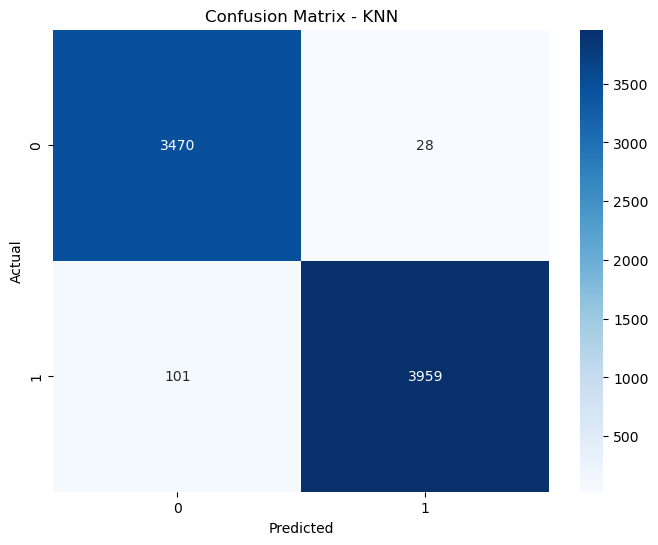

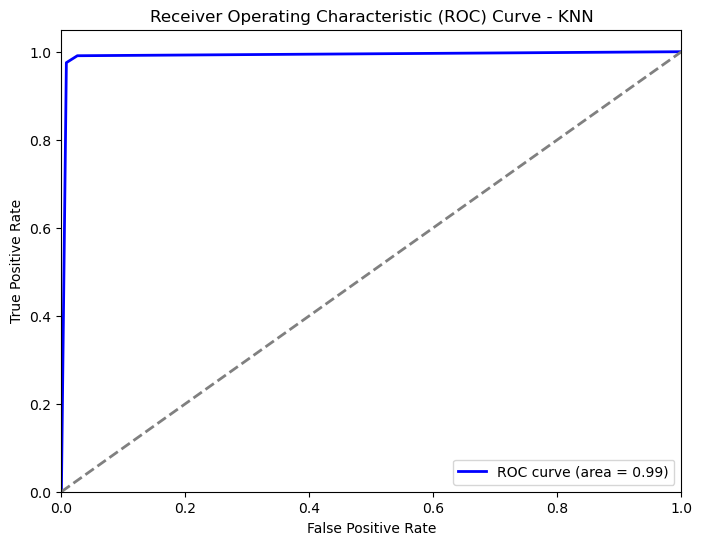

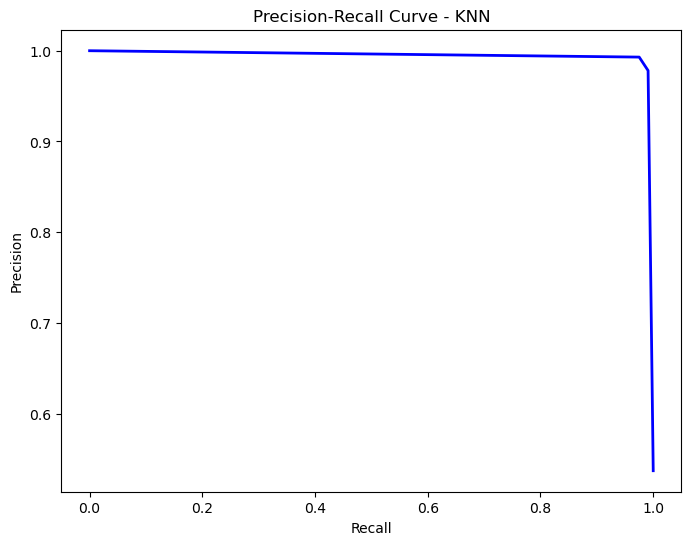

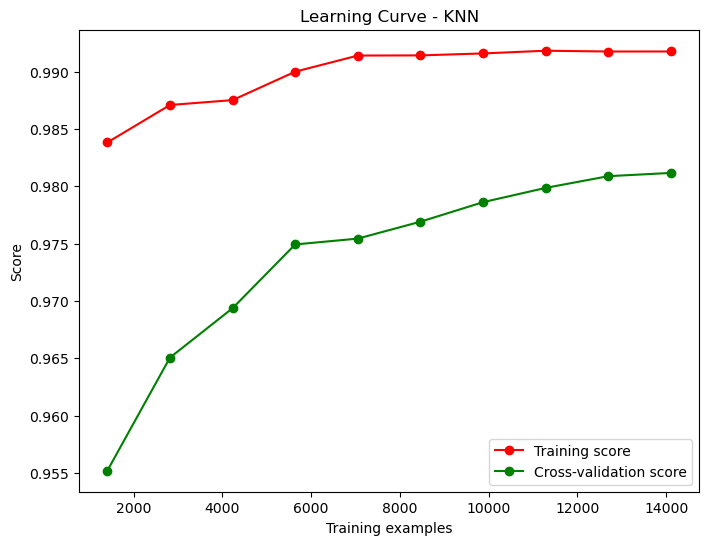

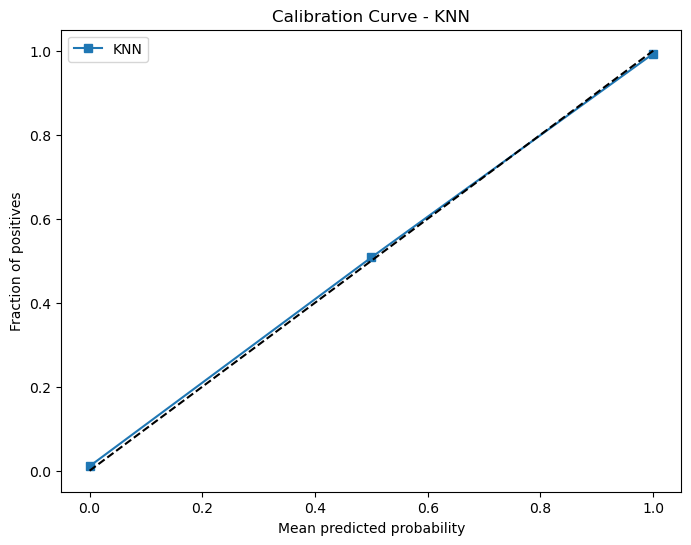

2024-08-07 00:37:37,340 - INFO - Evaluating model: Logistic Regression


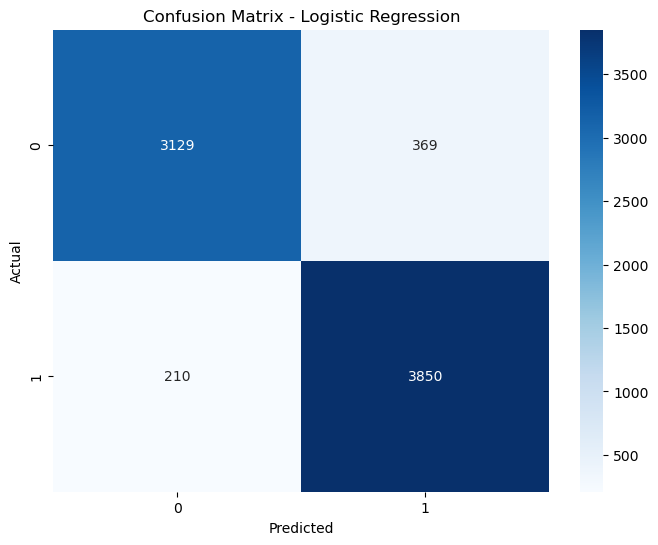

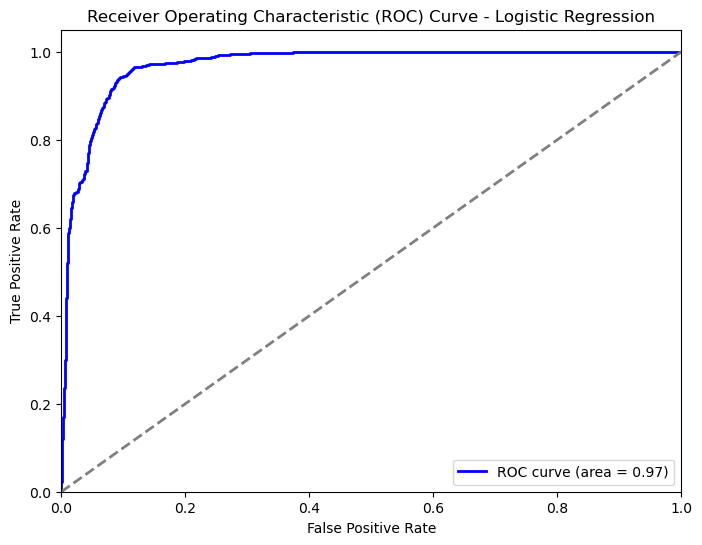

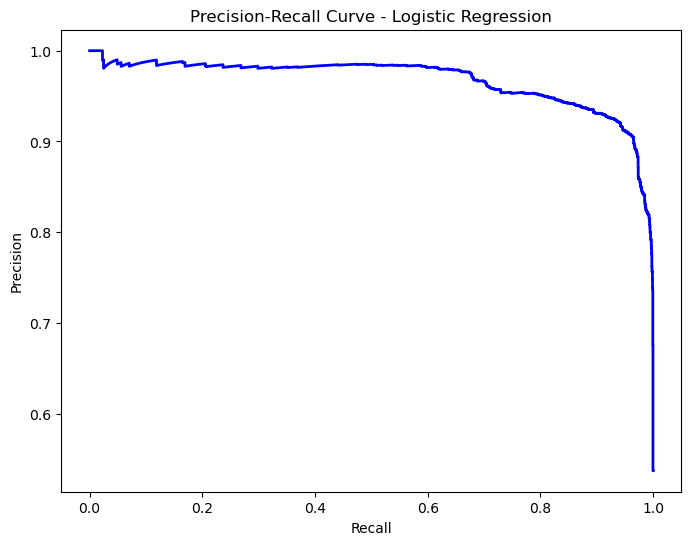

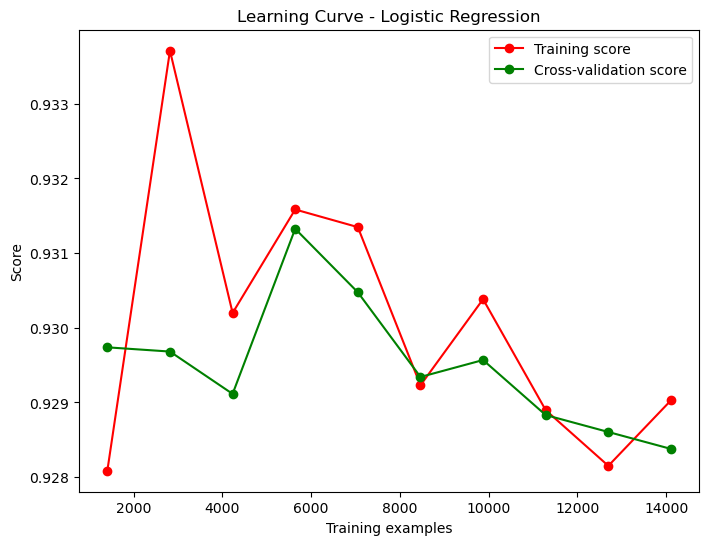

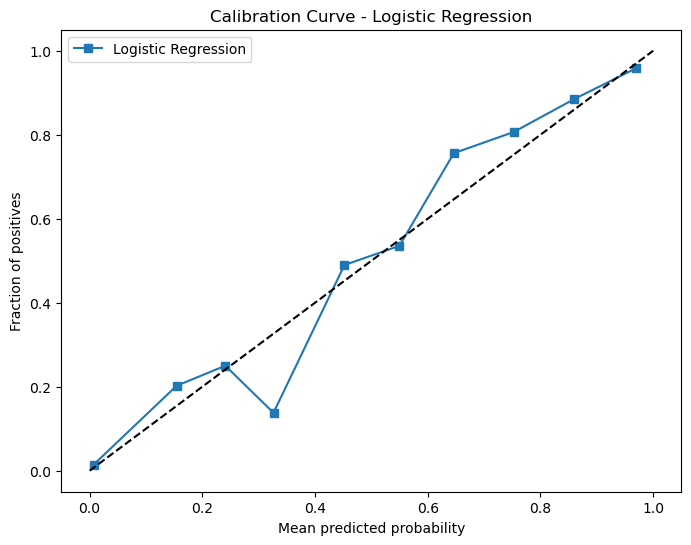

2024-08-07 00:37:42,342 - INFO - Evaluating model: Decision Tree


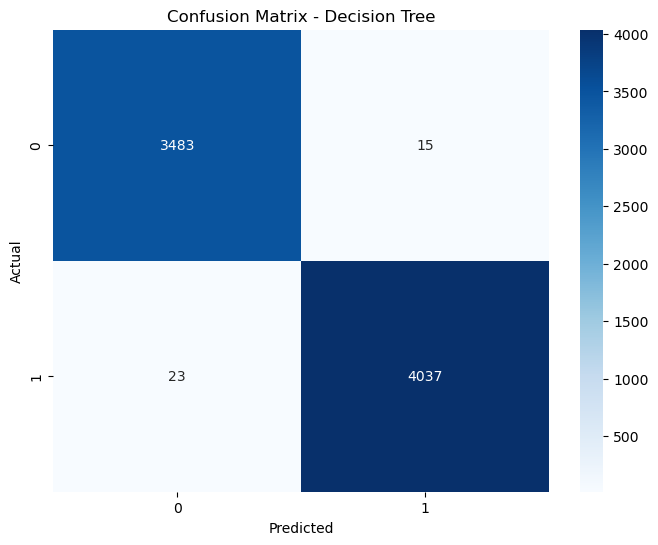

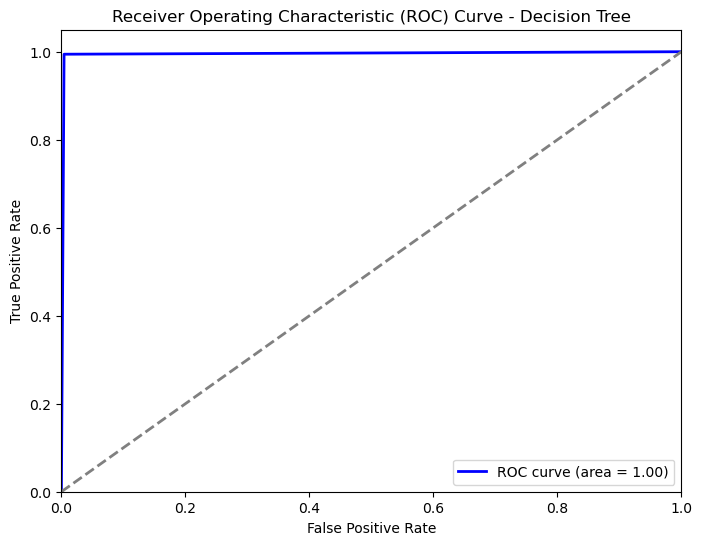

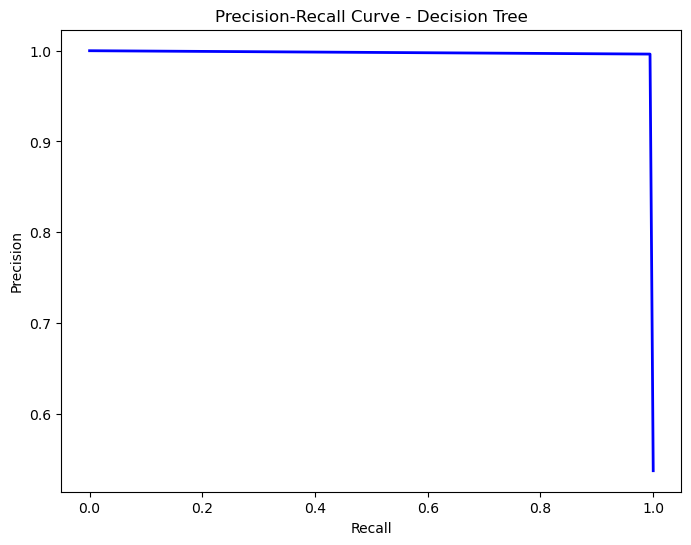

2024-08-07 00:37:44,311 - ERROR - Error evaluating model Decision Tree: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:37:44,311 - INFO - Evaluating model: Random Forest


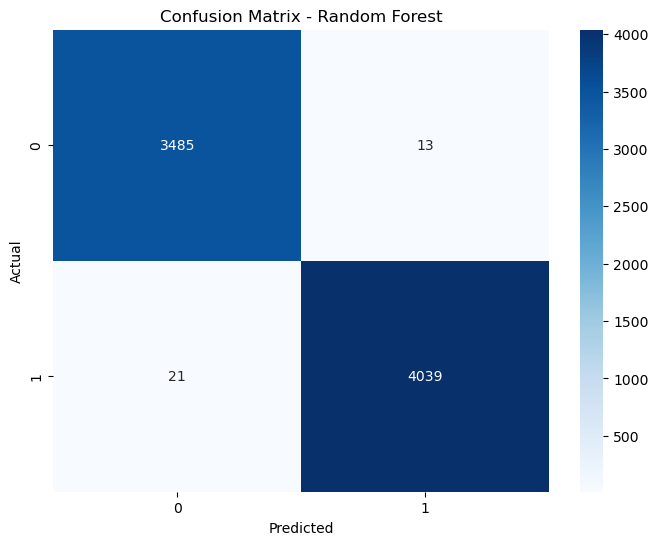

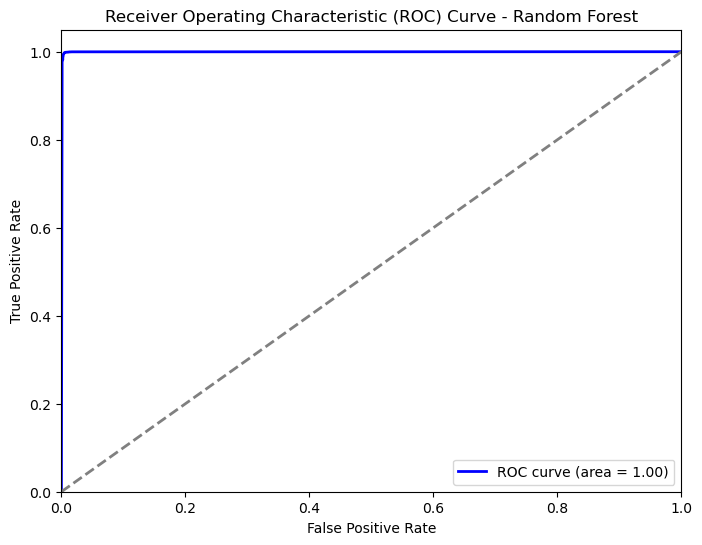

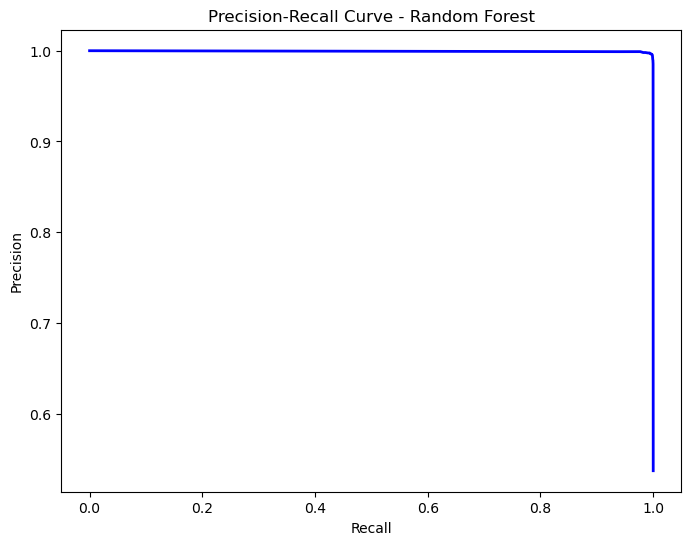

2024-08-07 00:37:46,898 - ERROR - Error evaluating model Random Forest: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:37:46,899 - INFO - Evaluating model: GBM


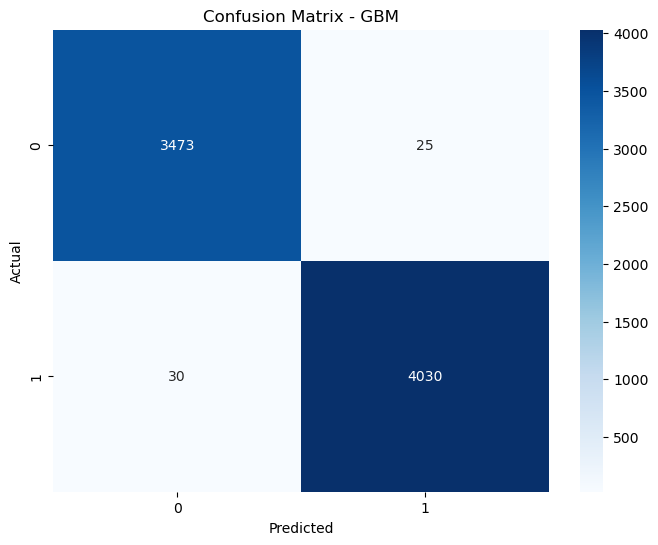

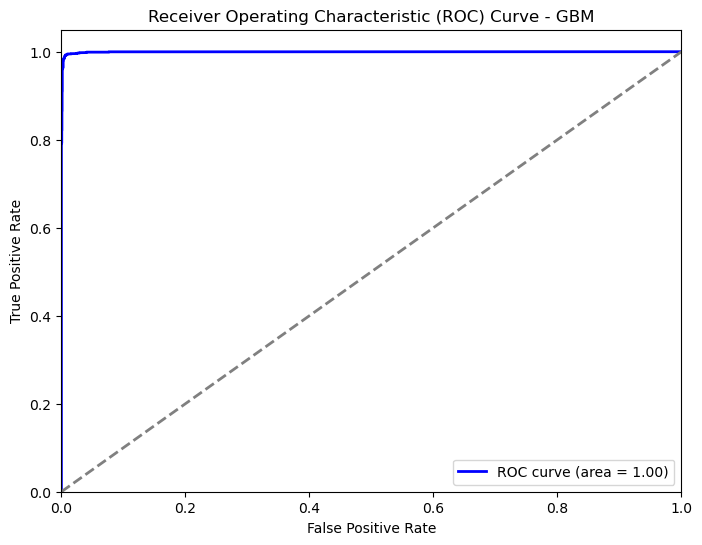

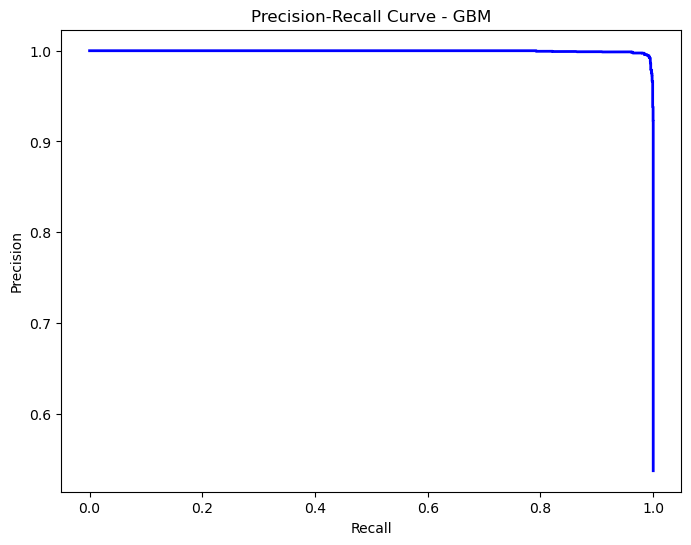

2024-08-07 00:37:53,796 - ERROR - Error evaluating model GBM: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:37:53,796 - INFO - Evaluating model: XGBM


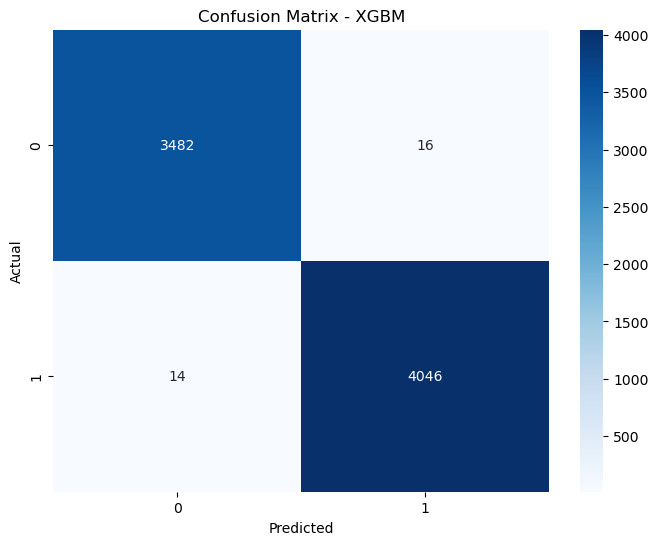

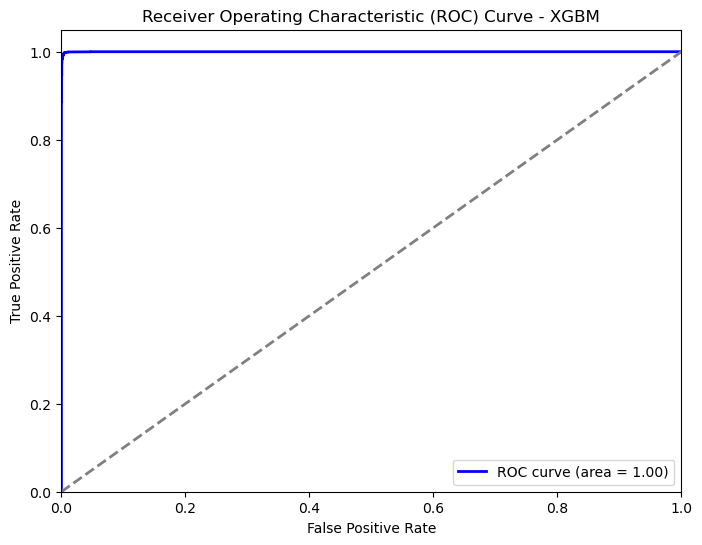

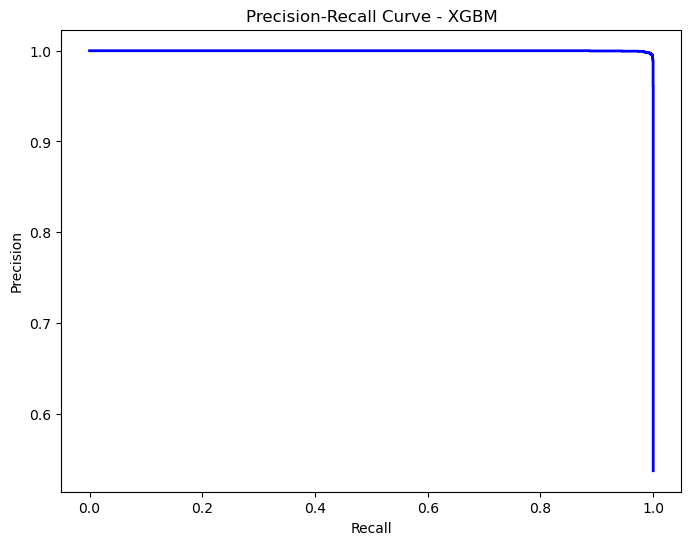

2024-08-07 00:37:56,166 - ERROR - Error evaluating model XGBM: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:37:56,169 - INFO - Evaluating model: Adaboost


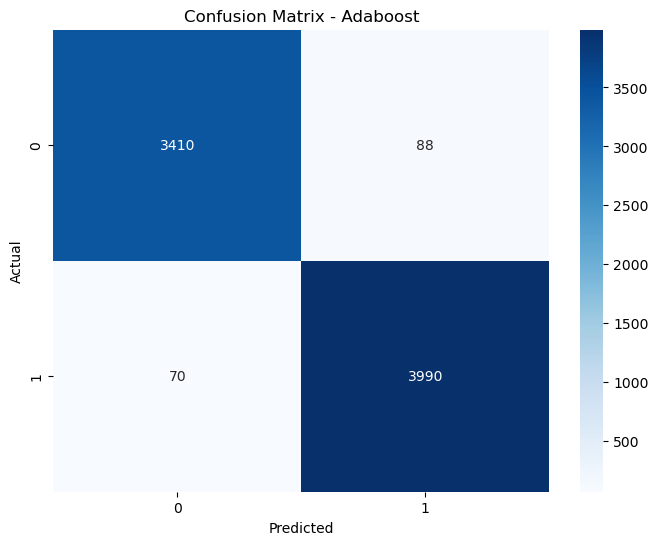

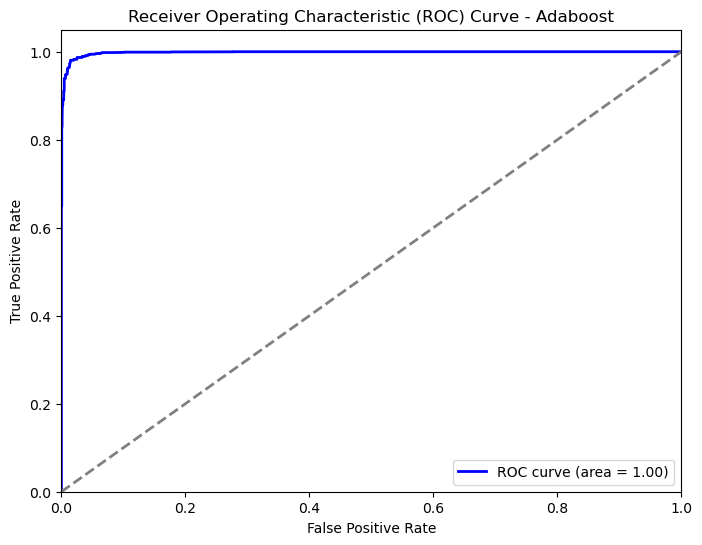

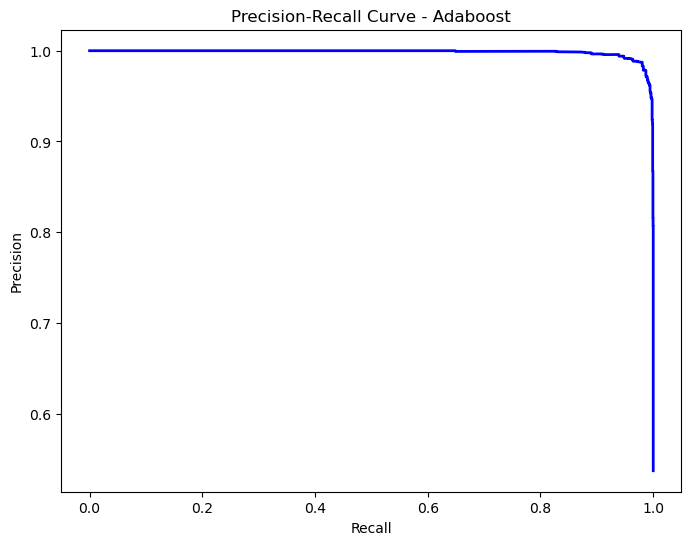

2024-08-07 00:37:59,269 - ERROR - Error evaluating model Adaboost: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:37:59,270 - INFO - Evaluating model: Light GBM


[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


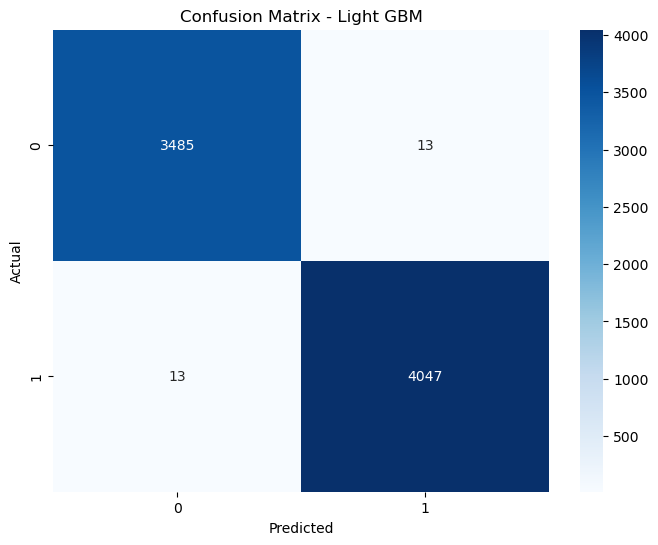

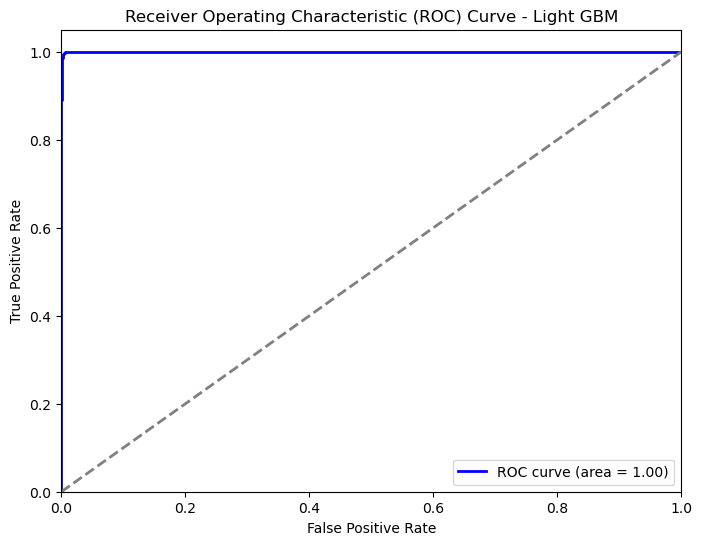

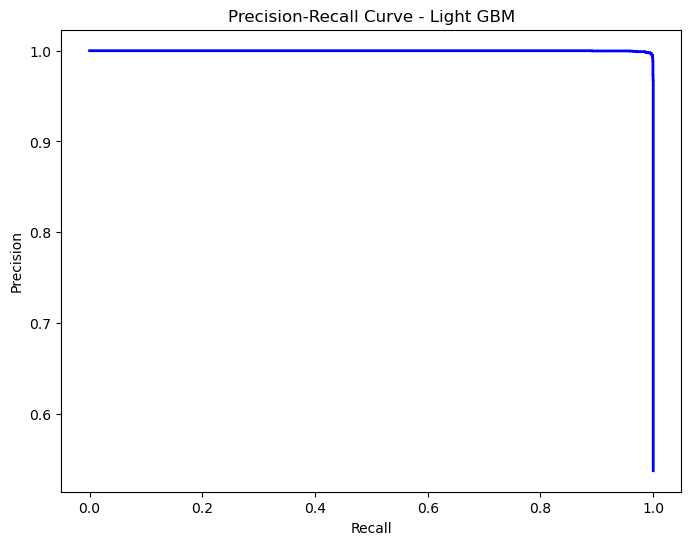

2024-08-07 00:38:01,531 - ERROR - Error evaluating model Light GBM: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:38:01,531 - INFO - Evaluating model: CatBoost


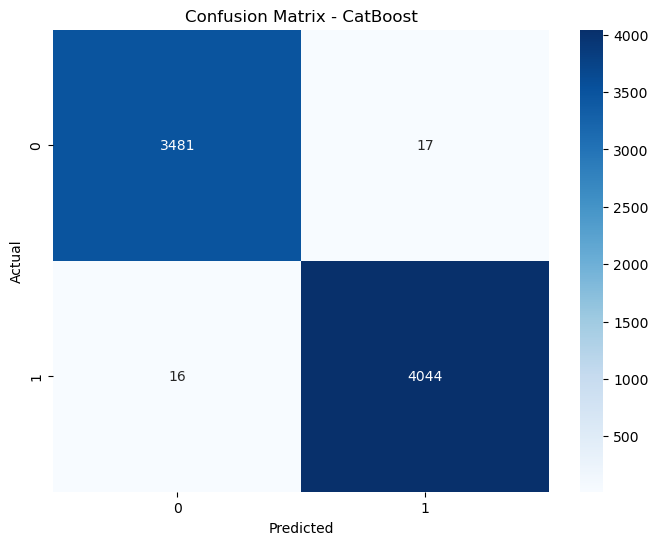

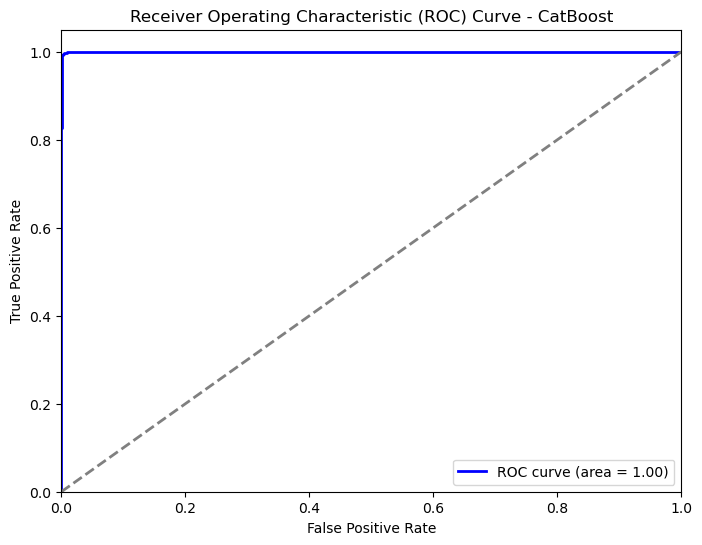

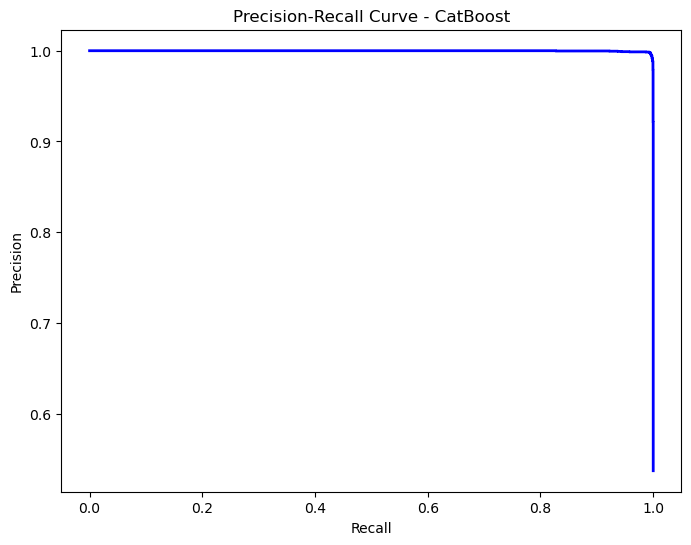

2024-08-07 00:38:24,208 - ERROR - Error evaluating model CatBoost: 'numpy.ndarray' object has no attribute 'columns'
2024-08-07 00:38:24,210 - INFO - Evaluating model: Naive Bayes


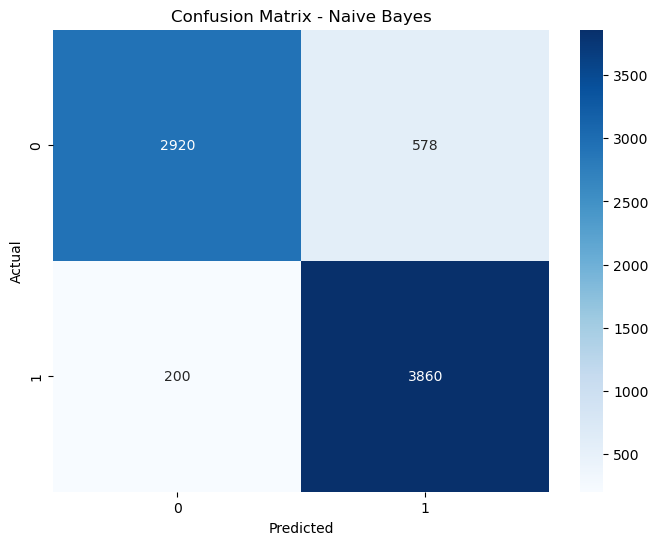

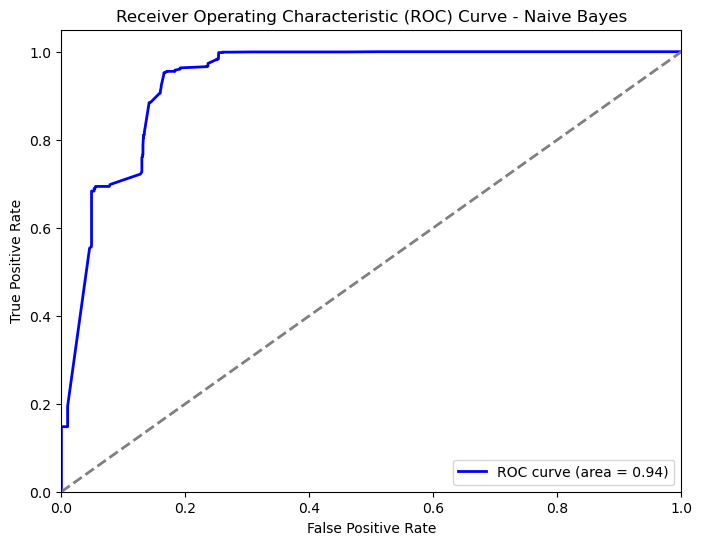

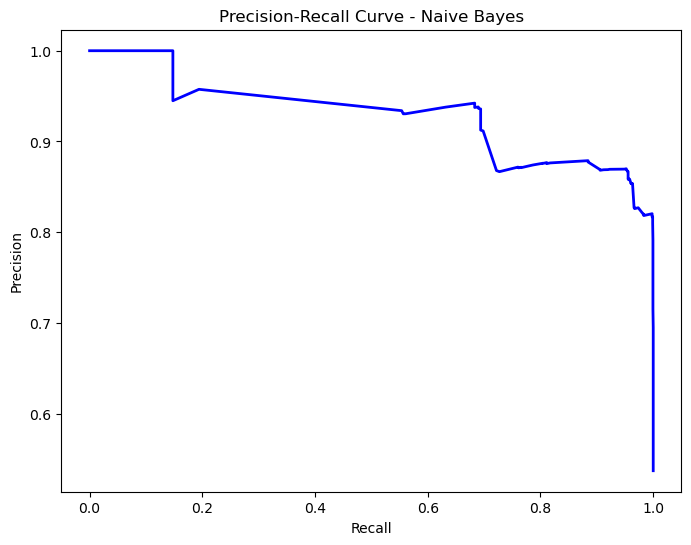

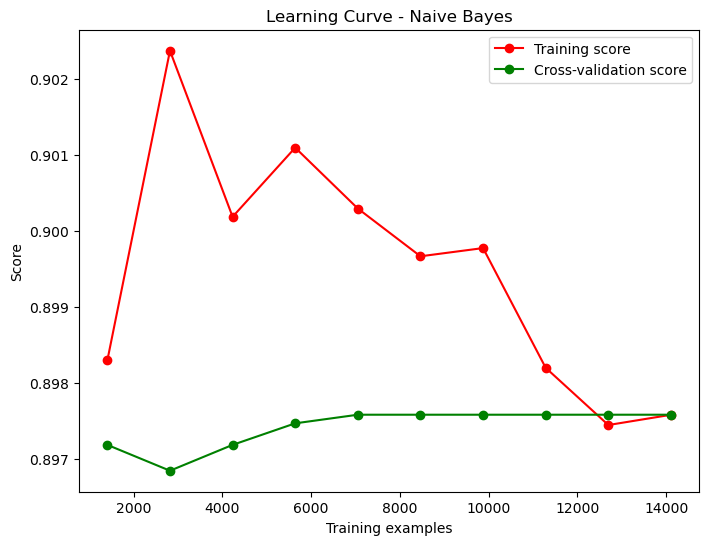

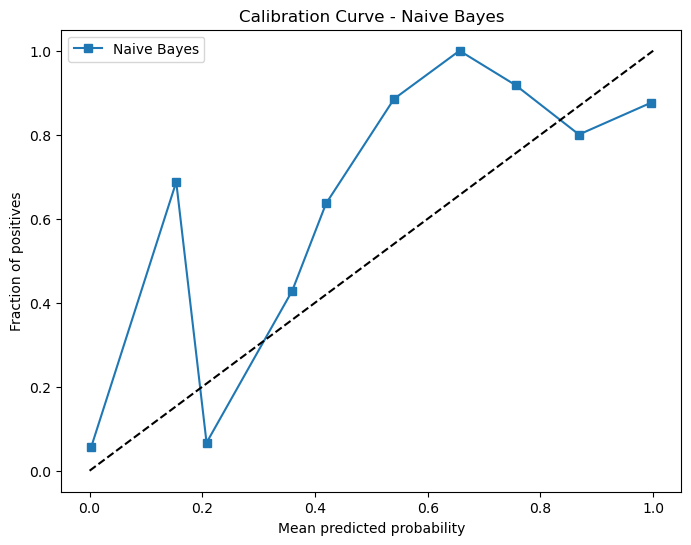

2024-08-07 00:38:28,397 - INFO - Evaluating model: Voting


[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


2024-08-07 00:39:01,257 - ERROR - Error evaluating model Voting: 'VotingClassifier' object has no attribute 'decision_function'


In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
import logging

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Assuming you have a train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Example models dictionary
models = {
    "KNN": KNN_model,
    "Logistic Regression": lg_model,
    "Decision Tree": dt,
    "Random Forest": rf,
    "GBM": SKGB,
    "XGBM": xgb_model,
    "Adaboost": ab_model,
    "Light GBM": lgb_model,
    "CatBoost": cb_model,
    "Naive Bayes": BNB_model,
    "Voting": v_clf
}

# Function to evaluate models and plot visualizations
def evaluate_models(models, X_train, X_test, y_train, y_test):
    for name, model in models.items():
        try:
            logging.info(f'Evaluating model: {name}')
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
            
            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()
            
            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, color='blue', lw=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {name}')
            plt.show()
            
            # Feature Importance (for tree-based models)
            if hasattr(model, "feature_importances_"):
                importance = model.feature_importances_
                feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
                feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
                
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_importance)
                plt.title(f'Feature Importance - {name}')
                plt.show()
            
            # Learning Curve
            train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
            train_scores_mean = np.mean(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            
            plt.figure(figsize=(8, 6))
            plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
            plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
            plt.xlabel('Training examples')
            plt.ylabel('Score')
            plt.title(f'Learning Curve - {name}')
            plt.legend(loc='best')
            plt.show()
            
            # Calibration Curve
            prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
            plt.figure(figsize=(8, 6))
            plt.plot(prob_pred, prob_true, 's-', label=f'{name}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('Mean predicted probability')
            plt.ylabel('Fraction of positives')
            plt.title(f'Calibration Curve - {name}')
            plt.legend(loc='best')
            plt.show()
        
        except Exception as e:
            logging.error(f'Error evaluating model {name}: {e}')

# Example usage
evaluate_models(models, x_train, x_test, y_train, y_test)

#                                                        END 😊😊